In [10]:
import pandas as pd 
import numpy as np
from sklearn.feature_selection import SelectKBest ,chi2
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Data 
data = pd.read_csv('/Users/mario.iuliano/marios_env/Portfolio/test/feature_selection/churn/telco.csv')

In [ ]:
# Drop features 
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.drop(columns = ['customerid', 'totalcharges'], inplace=True)

In [ ]:
# Create data for encoding
X = data.drop(columns = ['churn'])
y = data['churn'].map({'Yes': 1, 'No': 0})

X = pd.get_dummies(X)

selector = SelectKBest(score_func= chi2, k = 'all')
X_selector = selector.fit_transform(X, y)

In [ ]:
# From the selector get the chi2 scores 
chi2_scores = selector.scores_

44

In [21]:
chi2_df = pd.DataFrame({
    'Features': X.columns,
    'Chi2 Score': chi2_scores
    }).sort_values(by = 'Chi2 Score', ascending = False)

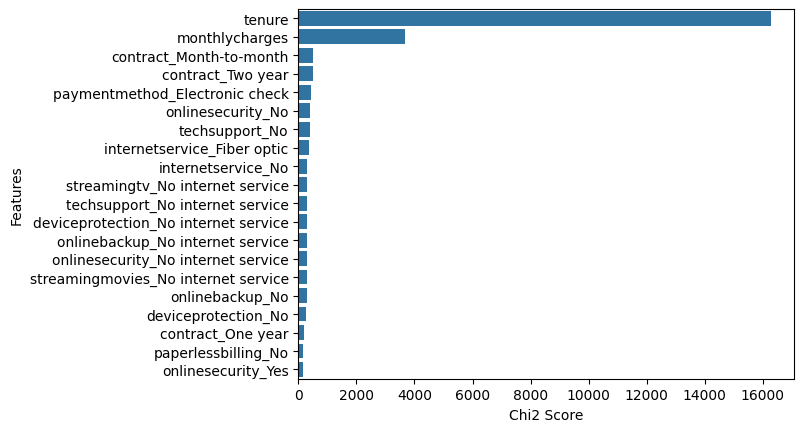

In [27]:
sns.barplot(data = chi2_df[:20], x = 'Chi2 Score', y = 'Features')
plt.show()

In [52]:
# Exclude 
exclude = [
                'onlinesecurity', 
                'onlinebackup',
                'streamingmovies', 
                'multiplelines'
            ]

In [53]:
# Select features
features = list(set([f.split('_')[0] for f in chi2_df[:20].Features if f.split('_')[0] not in exclude]))

In [54]:
# Add churn to features
features.append('churn')

In [55]:
data_fs = data[features]

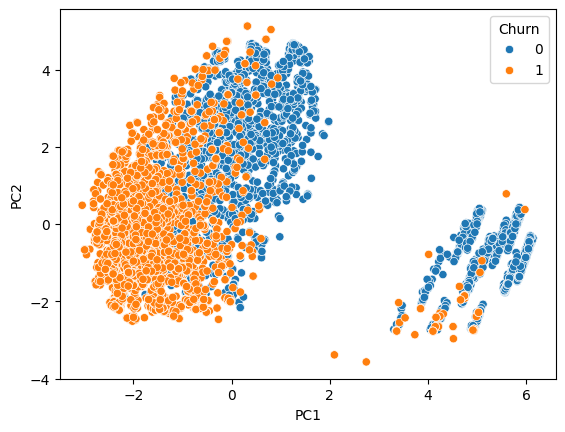

In [63]:
smote = SMOTEENN(random_state = 42)
X = data_fs.drop(columns = ['churn'])
X = pd.get_dummies(X)
y = data_fs['churn'].map({'Yes': 1, 'No': 0})
X_resampled, y_resampled = smote.fit_resample(X, y)

sc = StandardScaler()
X_scaled = sc.fit_transform(X_resampled)

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

pc1 = X_pca[:,0]
pc2 = X_pca[:,1]

pca_df = pd.DataFrame({
                        'PC1': pc1,
                        'PC2': pc2,
                        'Churn': y_resampled
                    })

sns.scatterplot(data = pca_df, x = 'PC1', y = 'PC2', hue = 'Churn')
plt.show()

In [76]:
pca_insights = pd.DataFrame({
                            'features':X_resampled.columns, 
                            'pca': pca.components_[0]
                            }).sort_values(by = 'pca', ascending = False)

print(pca_insights.head())
print(pca_insights.tail())

                                features       pca
22                    internetservice_No  0.333118
16  deviceprotection_No internet service  0.333118
13       streamingtv_No internet service  0.333118
6        techsupport_No internet service  0.333118
4                      contract_Two year  0.179196
                       features       pca
15          deviceprotection_No -0.220293
2       contract_Month-to-month -0.221889
21  internetservice_Fiber optic -0.249328
5                techsupport_No -0.270671
0                monthlycharges -0.283632


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)
rf = RandomForestClassifier(random_state = 42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [68]:
predictions = rf.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       567
           1       0.97      0.97      0.97       748

    accuracy                           0.97      1315
   macro avg       0.97      0.97      0.97      1315
weighted avg       0.97      0.97      0.97      1315



In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       567
           1       0.94      0.94      0.94       748

    accuracy                           0.93      1315
   macro avg       0.93      0.93      0.93      1315
weighted avg       0.93      0.93      0.93      1315



/Users/mario.iuliano/marios_env/Portfolio/.env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [80]:
coeff = lr.coef_[0]
odds_ratio = np.exp(coeff)

odds_df = pd.DataFrame({
    'features': X_resampled.columns,
    'odds_ratio': odds_ratio
}).sort_values(by = 'odds_ratio', ascending = False)

In [81]:
odds_df

,features,odds_ratio
10,paymentmethod_Electronic check,13.955491
19,paperlessbilling_Yes,7.940298
8,paymentmethod_Bank transfer (automatic),7.119633
2,contract_Month-to-month,6.802352
17,deviceprotection_Yes,6.625302
21,internetservice_Fiber optic,6.532855
11,paymentmethod_Mailed check,6.348096
5,techsupport_No,6.067182
14,streamingtv_Yes,5.672121
9,paymentmethod_Credit card (automatic),4.937238


1. paymentmethod_Electronic check (13.96)
Customers using Electronic Check as a payment method are about 14 times more likely to experience the event (e.g., churn or the outcome you're modeling) compared to those who use another payment method.

This is a very strong predictor.

2. paperlessbilling_Yes (7.94)
Customers who opt for paperless billing are almost 8 times more likely to experience the event compared to those who receive paper bills.

This is a strong predictor of the outcome.

3. paymentmethod_Bank transfer (automatic) (7.12)
Customers using automatic bank transfer as a payment method are about 7 times more likely to experience the event compared to other payment methods.

This is also a strong predictor.

4. contract_Month-to-month (6.80)
Customers on a month-to-month contract are about 7 times more likely to experience the event compared to customers on longer-term contracts (like yearly or two-year contracts).

This indicates that month-to-month contracts are strongly associated with the event (likely higher churn rates).

5. deviceprotection_Yes (6.63)
Customers who have device protection are about 6.6 times more likely to experience the event compared to those without device protection.

This suggests that device protection is a significant factor in predicting the outcome.

6. internetservice_Fiber optic (6.53)
Customers with fiber optic internet service are about 6.5 times more likely to experience the event compared to customers with other types of internet service.

This suggests that fiber optic customers may have higher likelihoods of the event.

7. paymentmethod_Mailed check (6.35)
Customers using mailed checks for payments are about 6.35 times more likely to experience the event compared to customers using other payment methods.

This is a strong predictor as well.

8. techsupport_No (6.07)
Customers who do not have tech support are about 6 times more likely to experience the event compared to those with tech support.

A lack of tech support appears to be a strong indicator of the outcome.

9. streamingtv_Yes (5.67)
Customers who have streaming TV are about 5.7 times more likely to experience the event compared to those who don't have streaming TV.

This suggests that having streaming TV is associated with a higher likelihood of the event.

10. paymentmethod_Credit card (automatic) (4.94)
Customers using automatic credit card payments are about 5 times more likely to experience the event compared to other payment methods.

This is a moderately strong predictor.

11. deviceprotection_No (4.85)
Customers without device protection are about 4.85 times more likely to experience the event compared to those with device protection.

This suggests that no device protection increases the likelihood of the event, though not as strongly as having device protection.

12. paperlessbilling_No (4.24)
Customers who opt for paper billing are about 4.24 times more likely to experience the event compared to those who use paperless billing.

This indicates that paper billing is a strong indicator of the event happening.

13. streamingtv_No (1.18)
Customers who do not have streaming TV are about 1.18 times more likely to experience the event compared to those with streaming TV.

This is a very small effect, suggesting that not having streaming TV slightly increases the likelihood of the event.

14. monthlycharges (0.94)
For each unit increase in monthly charges, the odds of the event decrease by about 6% (since the odds ratio is 0.94, which is less than 1).

This indicates that higher monthly charges are slightly associated with a lower likelihood of the event happening.

15. tenure (0.93)
For each one-month increase in tenure, the odds of the event decrease by about 7% (since the odds ratio is 0.93).

This suggests that customers who have been with the service for longer are less likely to experience the event (likely indicating lower churn for longer-tenured customers).

16. deviceprotection_No internet service (0.52)
Customers who have no device protection and no internet service are about half as likely to experience the event compared to those with device protection and internet service.

This might indicate that customers without both are less likely to experience the event.

17. internetservice_No (0.52)
Customers with no internet service are about half as likely to experience the event compared to customers with internet service.

This could suggest that customers without internet service are less likely to experience the event.

18. streamingtv_No internet service (0.52)
Customers with no internet service and no streaming TV are about half as likely to experience the event compared to those with both services.

This suggests a similar relationship to the one for "no internet service" alone.

19. techsupport_No internet service (0.52)
Customers with no tech support and no internet service are about half as likely to experience the event compared to customers with both services.

Again, this suggests that lacking both services reduces the likelihood of the event.

20. internetservice_DSL (0.05)
Customers with DSL internet service are about 95% less likely to experience the event compared to customers with other types of internet service.

This is a strong inverse predictor, suggesting that customers with DSL are far less likely to experience the event.

Summary:
High Odds Ratios (greater than 1): Features like payment methods (electronic check, bank transfer), contract type (month-to-month), and device protection are associated with a higher likelihood of the event.

Low Odds Ratios (less than 1): Features like tenure, monthly charges, and DSL internet service are associated with a lower likelihood of the event occurring.

In general, features related to customer service (like tech support and device protection), billing options (paperless, automatic payments), and service type (internet service, streaming TV) all seem to play a significant role in predicting the outcome.